In [28]:
import pandas as pd
import numpy as np
import pandas as pd
import os
import re
import time
from gensim.models import Word2Vec
from gensim.models import FastText
#from gensim.models.wrappers import FastText
from tqdm import tqdm
from pprint import pprint
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
from google.colab import files
import io
from sklearn.metrics import classification_report

In [25]:
%cd /content/drive/MyDrive/Work

/content/drive/MyDrive/Work


In [3]:
df=pd.read_csv('doc_humour.txt', delimiter=';', error_bad_lines=False, header=None)
#df = df.drop([0,1], axis=1)
df.columns=['Timestamp','Name','Utterance', 'humour_label']
df["humour_label"] = pd.to_numeric(df["humour_label"], errors='coerce')
df.dropna(inplace=True)

df.loc[df["humour_label"]==10.0, 'humour_label']=1.0
print(len(df))
print(len(df.loc[df["humour_label"]==1.0, 'humour_label']))

6465
842


b'Skipping line 769: expected 4 fields, saw 5\nSkipping line 1160: expected 4 fields, saw 6\nSkipping line 3896: expected 4 fields, saw 5\nSkipping line 4174: expected 4 fields, saw 5\n'


In [4]:
df['Name'] = df['Name'].replace(['Hero', 'Varun', ' Varunu', '06-18:08:Varun', 'varun', ' Varun'], 'Varun')
df['Name'] = df['Name'].replace(['Balraju', 'Bala Raju', 'bala Raju', 'Bala raju', ' Bala Raju'], 'Balraju')
df['Name'] = df['Name'].replace(['Heroine', 'Jagadamba', 'J', 'Jagadhamba', 'Jagdamba', 'Jagadhmba', 'Jagdhamba', ' Jagadhamba', 'Jgadhamba', 'Jagadhama'], 'Jagadamba')
df['Name'] = df['Name'].replace(['krishna', 'Krshna', 'Krishana', 'Kroshna'], 'Krishna')
df['Name'] = df['Name'].replace(['Heroine father', 'Jagadamba father', 'J father', 'Guravayya', 'Guravayy', ' J father', 'Guravyya'], 'Guruvayya') 
df['Name'] = df['Name'].replace(['Heroine grandma', 'Jagadamba grandma', 'J Grand mother', 'Baamma', 'J Grand Mother', 'Grand Mother'], 'J grandma')
df['Name'] = df['Name'].replace(['Boss'], 'Ramesh')
df['Name'] = df['Name'].str.replace('J.s Grand Moyther', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('J.s Grand Mother', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('Jagadhamba.s Grand Mother', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('J.sGrand Mother', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('Heroin.s Grand Mother', 'J grandma', regex=True)
df['Name'] = df['Name'].str.replace('Hero-in.s Father', 'Guruvayya', regex=True)
df['Name'] = df['Name'].str.replace('Heroin.s Father', 'Guruvayya', regex=True)
#AllNames = df['Name'].unique().tolist()

Dialogues_by_Speaker = df.groupby("Name")["Utterance"].count().nlargest(40)
print(Dialogues_by_Speaker.head(40))

df.loc[:, 'Labels'] = "Other"
df.loc[df['Name'] == 'Varun', 'Labels'] = "Varun"
df.loc[df['Name'] == 'Balraju', 'Labels'] = "Balraju"
df.loc[df['Name'] == 'Jagadamba', 'Labels'] = "Jagadamba"
df.loc[df['Name'] == 'Krishna', 'Labels'] = "Krishna"
df.loc[df['Name'] == 'Guruvayya', 'Labels'] = "Guruvayya"
df.loc[df['Name'] == 'Ramesh', 'Labels'] = "Ramesh"

print(df.head(20))

Name
Varun            1216
Jagadamba         709
Krishna           652
Balraju           398
Guruvayya         231
Ramesh            196
Mahesh            166
Ranga             162
J grandma         128
Nikhil            124
Madhur            117
SB                 97
Shobhan Babu       89
Baali Reddy        85
Puli               72
Sasmitha           71
Apsara             66
SSK                65
Divya              61
KS                 61
Rambabu            54
J mother           51
Simham             49
Rangi              38
Varun grandma      38
Jack               37
Sai Reddy          37
Sash               36
Kodi Raju          35
Bhavani            34
Varun father       34
Sarayu             33
Sree Reddy         33
Kaveri             31
Boo                30
RSK                29
Barbie             28
EM                 28
Roo                28
Sri Reddy          26
Name: Utterance, dtype: int64
      Timestamp             Name  ... humour_label     Labels
0   00:14-00:47        

In [29]:
from sklearn.model_selection import train_test_split
#from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

labels = df['humour_label'].values
sentences = df[['Labels','Utterance']].values

#categorical_labels = to_categorical(labels, num_classes=7)
combo_train, combo_test, y_train, y_test = train_test_split(sentences, labels, test_size = 0.25, random_state=1000)

sentences_train = combo_train[:, 1]
name_train = combo_train[:, 0]

sentences_test = combo_test[:, 1]
name_test = combo_test[:, 0]

lb = LabelBinarizer()
n_train = lb.fit_transform(name_train)
n_test = lb.transform(name_test)

In [6]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=13000, lower=True)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

print(sentences_train[2])
print(X_train[2])

 Evvadu ra dhaani ni ammedhi?
[240, 1, 136, 16, 3958]


In [7]:
from keras.preprocessing.sequence import pad_sequences

def pad_repeat(A, size=100):
  return np.vstack([np.resize(A[i], size) for i in range(len(A))])

maxlen = 100
embedding_dim = 300

X_train=pad_repeat(X_train,maxlen)
X_test=pad_repeat(X_test,maxlen)

In [8]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    
    return embedding_matrix


#uploaded=files.upload()
embedding_matrix = create_embedding_matrix('FastTextVectorsFinal.txt', tokenizer.word_index, embedding_dim)

# New Section

In [9]:
import tensorflow.keras as keras
import sys

class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    # def on_train_batch_end(self, batch, logs=None):
    #     sys.stdout.write("\rFor batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    # def on_test_batch_end(self, batch, logs=None):
    #     sys.stdout.write("\rFor batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    def on_epoch_end(self, epoch, logs=None):
        sys.stdout.write("\rEpoch finished {:d}.".format(epoch))


In [70]:
from sklearn.metrics import precision_recall_curve

def transform_predictions(y_i_test, predictions_i):
    precision, recall, thresholds = precision_recall_curve(y_i_test, predictions_i)
    f1 = (2 * precision * recall)/ (precision + recall)
    threshold = thresholds[np.argmax(f1)]
    return np.where(predictions_i >= 0.15, 1.0, 0.0)
  # return np.hstack([cot_i(y_test[:,i], predictions[:, i]).reshape(-1,1) for i in range(y_test.shape[1])])

In [31]:
from keras import backend
import tensorflow as tf


def accuracy_c(y_true, y_pred, threshold=0.35):
  # y_pred_n = transform_predictions(y_true, y_pred)
  y_pred_n = tf.where(y_pred > threshold, 1.0, 0.0)
  y_pred = backend.clip(y_pred, 0.0, 1.0)
  return backend.mean(tf.where(y_pred_n == y_true, 1, 0))

def accuracy_t(y_true, y_pred, threshold=0.5):
    y_pred = backend.clip(y_pred, 0, 1)
    tp = tf.where(backend.clip(y_true * y_pred, 0.0, 1.0) >= threshold, 1.0,0.0)
    tn = tf.where(backend.clip(y_pred - y_true, 0.0, 1.0) < threshold, 1.0, 0.0)
    fp = tf.where(backend.clip(y_pred - y_true, 0.0, 1.0) >= threshold, 1.0,0.0)
    fn = tf.where(backend.clip(y_true - y_pred, 0.0, 1.0) >= threshold, 1.0, 0.0)
    return backend.mean((tp+ tn) / (tp + tn + fp + fn))


In [32]:
import numpy as np


class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [33]:
from keras.models import Sequential, Model
from keras.layers.merge import Concatenate, Average   
from keras import layers
from tensorflow.keras.layers import Reshape,Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D, Conv2D,MaxPooling2D, MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU, Flatten
from tensorflow.keras import regularizers
import sys

input_shape = (maxlen,)
model_input = Input(shape=input_shape)
EmbedLayer = Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False)(model_input)
EmbedLayer = Dropout(0.4)(EmbedLayer)
LSTMLayer = (Bidirectional(LSTM(230,dropout=0.5, return_sequences=True, recurrent_dropout=0.5)))(EmbedLayer)
LSTMLayer = Reshape((maxlen, 2*230, 1))(LSTMLayer) 
LSTMLayer = Dropout(0.2)(LSTMLayer)

Filter1 = Conv2D(115, kernel_size=(6,6),kernel_regularizer=regularizers.l2(0.00001), padding='same')(LSTMLayer)
Filter1 = LeakyReLU(alpha=0.2)(Filter1)
Filter1 = MaxPooling2D(pool_size=(2))(Filter1)
# model1.add(SpatialDropout2D(0.5))
Filter1 = Flatten()(Filter1)
Filter1 = Dropout(0.4)(Filter1)



Filter2 = Input(shape=(7,))
# Filter2 = Conv2D(50, kernel_size=(8,8),kernel_regularizer=regularizers.l2(0.00001), padding='same')(EmbedLayer)
# Filter2 = LeakyReLU(alpha=0.2)(Filter2)
# Filter2 = MaxPooling2D(pool_size=2)(Filter2)
# # model2.add(SpatialDropout1D(0.5))
# Filter2 = Flatten()(Filter2)

# merged = Concatenate()([Filter1, Filter2])

merged = Concatenate()([Filter1, Filter2])
merged = Dense(32, activation='relu')(merged)
merged = Dense(16, activation='relu')(merged)
model_output = Dense(1,activation='sigmoid')(merged)

model = Model([model_input, Filter2], model_output)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[accuracy_t])
model.summary()
print(y_train.shape, y_test.shape)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     3359700     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 460)     977040      dropout_3[0][0]                  
____________________________________________________________________________________________

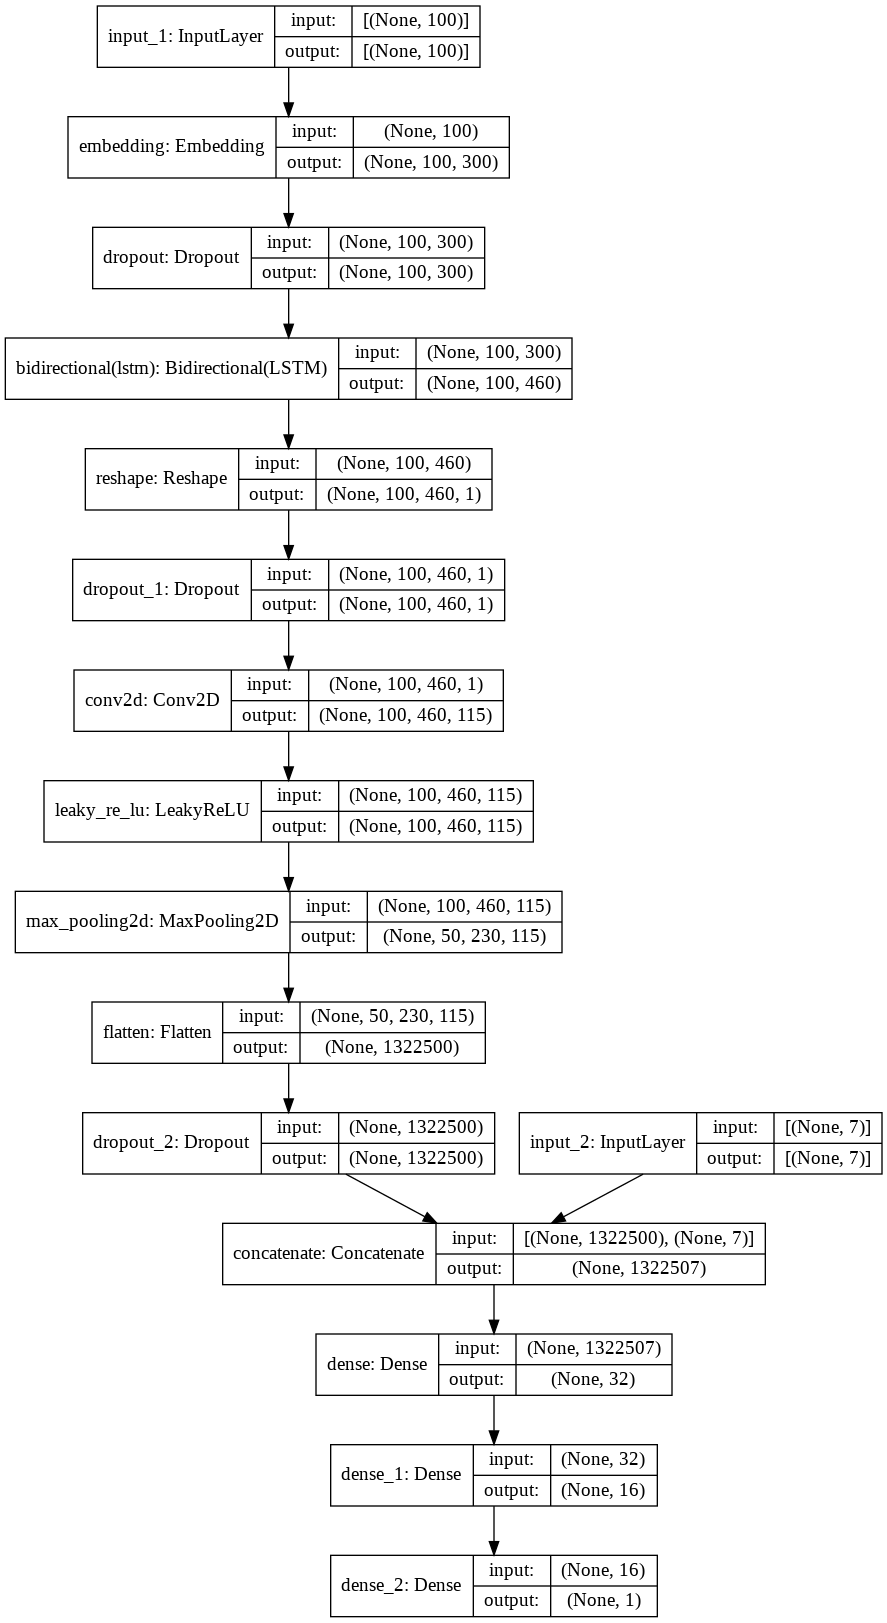

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [52]:
import matplotlib.pyplot as plt
import argparse

history = model.fit([X_train, n_train], y_train,
                    epochs=20,  
                    verbose=True,
                    validation_split=0.1,
                    batch_size=64, callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = f'bilstm', monitor='val_loss', save_best_only=True)]) 


Epoch 1/20
69/69 [==============================] - 120s 2s/step - loss: 0.2846 - accuracy_t: 0.9389 - val_loss: 0.4336 - val_accuracy_t: 0.8986
INFO:tensorflow:Assets written to: bilstm/assets
Epoch 2/20
69/69 [==============================] - 114s 2s/step - loss: 0.2763 - accuracy_t: 0.9401 - val_loss: 0.3874 - val_accuracy_t: 0.9200
INFO:tensorflow:Assets written to: bilstm/assets
Epoch 3/20
69/69 [==============================] - 116s 2s/step - loss: 0.2645 - accuracy_t: 0.9420 - val_loss: 0.4466 - val_accuracy_t: 0.8742
Epoch 4/20
69/69 [==============================] - 110s 2s/step - loss: 0.2615 - accuracy_t: 0.9452 - val_loss: 0.4214 - val_accuracy_t: 0.9137
Epoch 5/20
69/69 [==============================] - 111s 2s/step - loss: 0.2443 - accuracy_t: 0.9481 - val_loss: 0.4129 - val_accuracy_t: 0.8903
Epoch 6/20
69/69 [==============================] - 110s 2s/step - loss: 0.2297 - accuracy_t: 0.9514 - val_loss: 0.4389 - val_accuracy_t: 0.8912
Epoch 7/20
69/69 [==============

In [18]:
predictions.reshape(-1)

array([0.24158505, 0.09007132, 0.08206127, ..., 0.43450558, 0.07226203,
       0.09397089], dtype=float32)

In [63]:
model = keras.models.load_model("bilstm", custom_objects={'accuracy_t':accuracy_t})

[INFO] evaluating network...
[0.13925974 0.06299417 0.04606379 ... 0.0311791  0.05291462 0.0518358 ]
DescribeResult(nobs=1617, minmax=(0.00307986, 0.6021786), mean=0.12869374, variance=0.0101313405, skewness=1.4113353490829468, kurtosis=2.344819747286797)
[0. 0. 0. ... 0. 0. 0.]
              precision    recall  f1-score   support

         0.0       0.88      0.67      0.76      1399
         1.0       0.16      0.39      0.22       218

    accuracy                           0.63      1617
   macro avg       0.52      0.53      0.49      1617
weighted avg       0.78      0.63      0.69      1617

[INFO] serializing network and label binarizer...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


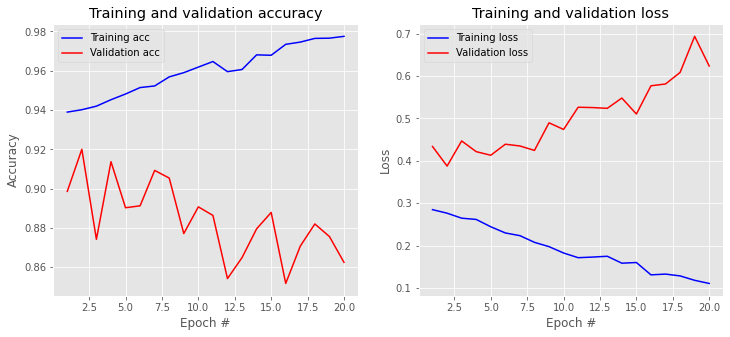

In [71]:
from scipy import stats
print("[INFO] evaluating network...")
predictions = model.predict(x=[X_test, n_test], batch_size=16).reshape(-1)
print(predictions)
print(stats.describe(predictions))
print(y_test)
print(classification_report(y_test, transform_predictions(y_test, predictions)))

plt.style.use('ggplot')

def plot_history(history):
    #N = np.arrange(0, 50) #no of Epochs
    acc = history.history['accuracy_t']
    val_acc = history.history['val_accuracy_t']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    #plt.savefig(args["plot"])

plot_history(history)

print("[INFO] serializing network and label binarizer...")
#model.save(args["model"], save_format="h5")

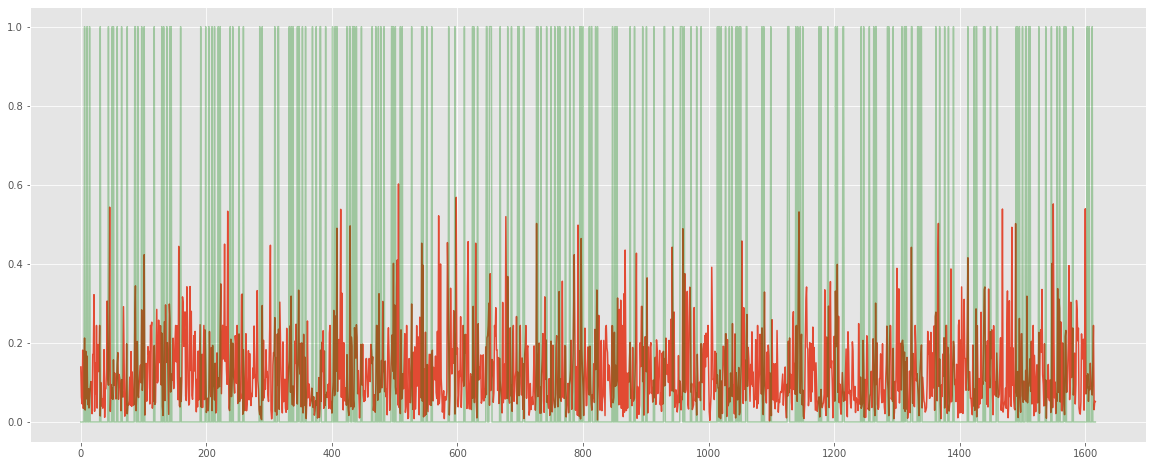

In [69]:
plt.figure(figsize=(20,8))
# plt.plot(range(len(predictions)), transform_predictions(y_test, predictions))
plt.plot(range(len(predictions)), predictions)
plt.plot(range(len(y_test)), y_test, color='g', alpha=0.3)
# plt.show()

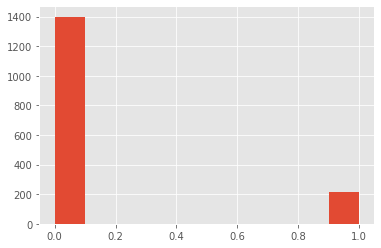

In [17]:
pd.Series(y_test).hist()

In [171]:
1400/1600

0.875